<a href="https://colab.research.google.com/github/Ashik9576/NYC-Taxi-Time-Prediction/blob/main/AshikNYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

# **Imporing the required Libraries**

In [123]:
# Importing the libraries
!pip install pycountry
!pip install haversine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pycountry as pc
import matplotlib.ticker as mtick
import plotly.express as px
from numpy import math
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [124]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading Data**

In [125]:
# creating directory path
nyc = pd.read_csv('/content/drive/MyDrive/NYC/NYC Taxi Data.csv')

**Creating Copy of Data**

In [126]:
# creating a copy
nycc=nyc.copy()

# **File Structure and content**

In [127]:
#no. of row and column
print("We have {} rows.".format(nycc.shape[0]))
print("We have {} columns.".format(nycc.shape[1]))
nycc.iloc[1,:]

We have 1458644 rows.
We have 11 columns.


id                              id2377394
vendor_id                               1
pickup_datetime       2016-06-12 00:43:35
dropoff_datetime      2016-06-12 00:54:38
passenger_count                         1
pickup_longitude                 -73.9804
pickup_latitude                   40.7386
dropoff_longitude                -73.9995
dropoff_latitude                  40.7312
store_and_fwd_flag                      N
trip_duration                         663
Name: 1, dtype: object

**At first galance, We have seen that the type of each variable and how they look like.**

# **MISSING VALUES**
Knowing about missing values is important because they indicate how much we dont's know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.


In [128]:
#check null values in Data frame
nyc.isnull().sum()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

**Fortunately, in this dataset we do not have any missing values which is great**

# **Describing Dataset**

In [129]:
# Visualizing the dataset
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [130]:
# summery of dataframe
nyc.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [131]:
nycc['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [132]:
nycc['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

# **Reformatting features**

There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features.

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration

In [133]:
#converting string to datetime features
nycc['pickup_datetime']=pd.to_datetime(nycc.pickup_datetime)
nycc['dropoff_datetime']=pd.to_datetime(nycc.dropoff_datetime)

#converting yes/no flag to 1 and 0
nycc['store_and_fwd_flag']=1*(nycc.store_and_fwd_flag.values=='Y')

nycc['check_trip_duration'] = (nycc['dropoff_datetime'] - nycc['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = nycc[np.abs(nycc['check_trip_duration'].values  - nycc['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

This implies that there is no inconsistency in data wrt the drop location and trip duration

In [134]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2124.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,429.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,435.0


# **Target Exploration and Data Visualization**
In this section we will take at the trip duration is the target variable. It is crucial to understand it in detail as this is what we ate trying to predict accurately.

In [135]:
nycc['trip_duration'].describe()/3600   # trip_duration in hour

count    405.178889
mean       0.266526
std        1.454842
min        0.000278
25%        0.110278
50%        0.183889
75%        0.298611
max      979.522778
Name: trip_duration, dtype: float64

Hey! There is a trip with duration of 979 hours. This is a huge outlier and might create problem at the prediction stage. One idea is to log transform the trip duration before prediction to visualize it before.

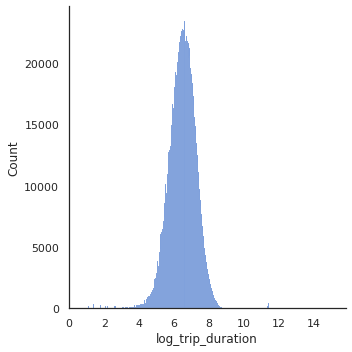

In [136]:
nycc['log_trip_duration']=np.log(nycc['trip_duration'].values+1)
sns.displot(nycc['log_trip_duration'], kde=False, bins=500)
plt.show()

1. There are several suspiciously short rides with less than 10 seconds duration
2. As discussed earlier, there are few huge outliers near 12.

**Univariate Visualization**

{0: 60,
 1: 1033540,
 2: 210318,
 3: 59896,
 4: 28404,
 5: 78088,
 6: 48333,
 7: 3,
 8: 1,
 9: 1}

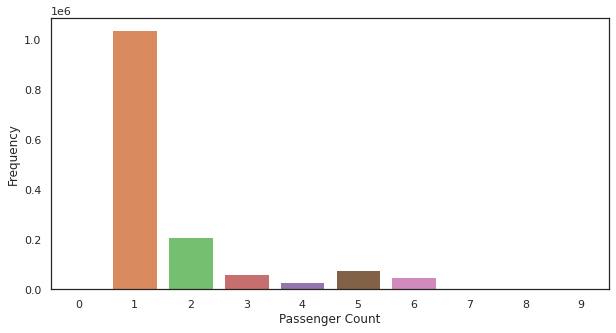

In [137]:
# Passenger count
plt.figure(figsize=(10,5))
sns.countplot(nycc['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')

dict(nycc['passenger_count'].value_counts())

**Most of the trip involves only 1 passenger. There are trips with 7-9 passenger but they are very low in nummber.**

Text(0, 0.5, 'Frequency')

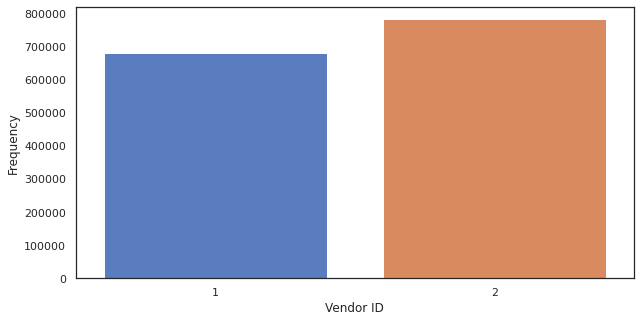

In [138]:
# Vendor count
plt.figure(figsize=(10,5))
sns.countplot(nycc['vendor_id'])
plt.xlabel('Vendor ID')
plt.ylabel('Frequency')

**Vendor 2 has more number of trips as compare to vendor1.**

0    1450599
1       8045
Name: store_and_fwd_flag, dtype: int64

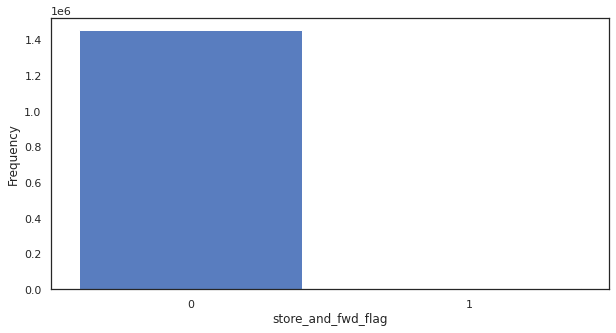

In [139]:
# store and fwd flag count
plt.figure(figsize=(10,5))
sns.countplot(nycc['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')

nycc['store_and_fwd_flag'].value_counts()

The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor('0') or held in the memory of the taxi because there was no connection to the server('1'), show that there was almost no storing taking place.

Now, we will delve into the datetime features to understand the trend of number of hourly/monthly/daily taxi trips

In [140]:
nycc['pickup_datetime'].min(), nycc['pickup_datetime'].max()

(Timestamp('2016-01-01 00:00:17'), Timestamp('2016-06-30 23:59:39'))

Clearly, These trips are for first 6 months of 2016. To look at trends, we first need to extract week days and hour of day from the pickup date.

In [141]:
# creating a new column(day_of_week) from the pickup_datetime column
nycc['day_of_week']=nycc['pickup_datetime'].dt.weekday
# creating a new column(hour_of_week) from the pickup_datetime column
nycc['hour_of_day']=nycc['pickup_datetime'].dt.hour

Text(0, 0.5, 'frequency')

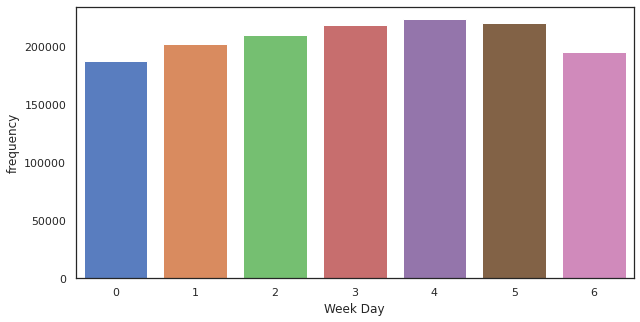

In [142]:
plt.figure(figsize=(10,5))
sns.countplot(nycc['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('frequency')

**Number of pickups for weekends is much lower than weeks days with a peak on Thurusday(4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday**

Text(0, 0.5, 'frequency')

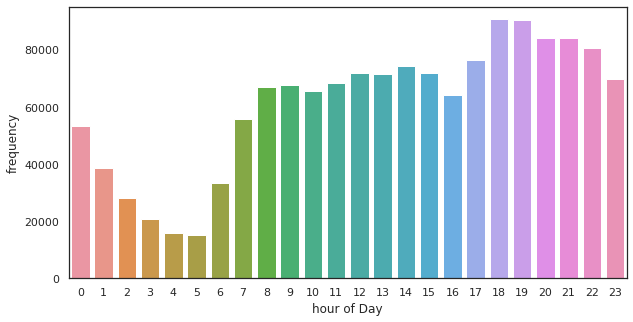

In [143]:
plt.figure(figsize=(10,5))
sns.countplot(nycc['hour_of_day'])
plt.xlabel('hour of Day')
plt.ylabel('frequency')

Number of pickups as expected is highest in late evening. However, it is much lower during the morning peak hours.

**Lattitude & Longitude**

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

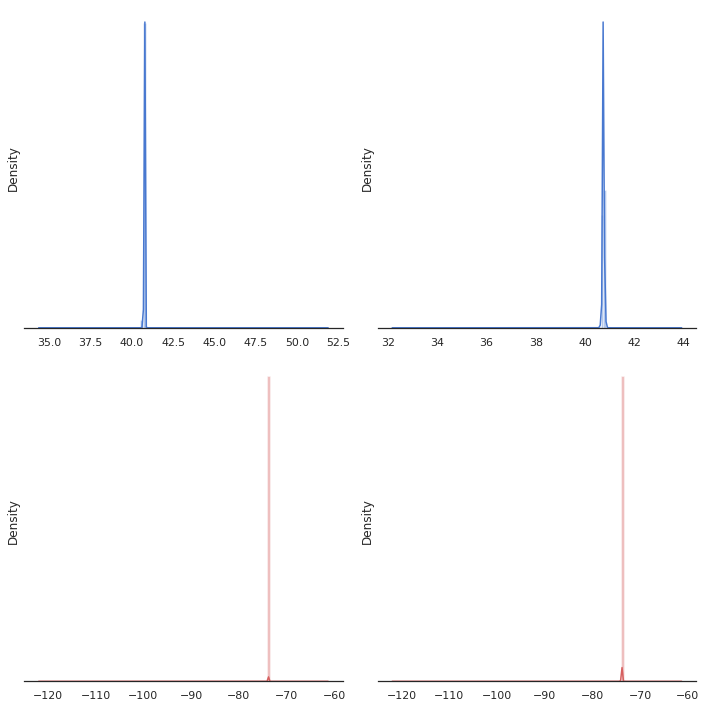

In [144]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(nycc['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(nycc['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(nycc['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(nycc['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73.
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

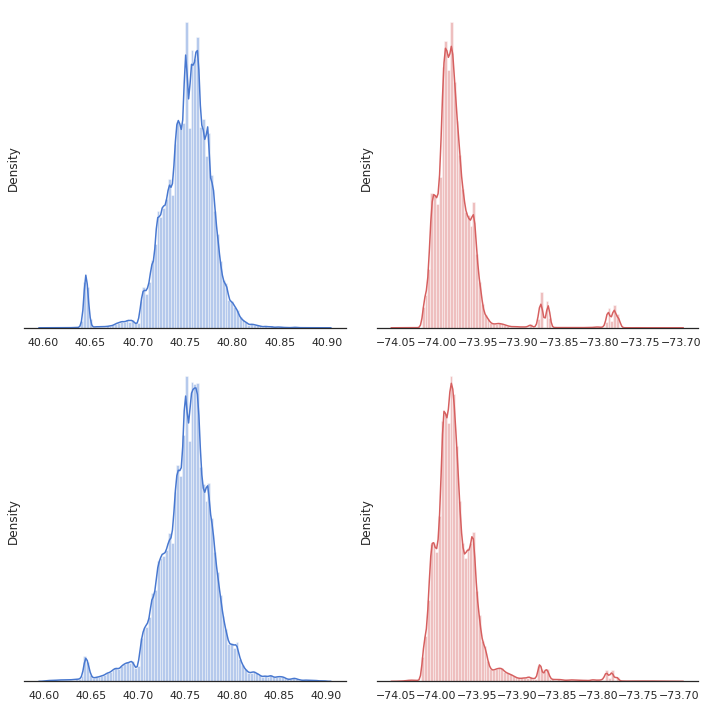

In [145]:
nycc = nycc.loc[(nycc.pickup_latitude > 40.6) & (nycc.pickup_latitude < 40.9)]
nycc = nycc.loc[(nycc.dropoff_latitude>40.6) & (nycc.dropoff_latitude < 40.9)]
nycc = nycc.loc[(nycc.dropoff_longitude > -74.05) & (nycc.dropoff_longitude < -73.7)]
nycc = nycc.loc[(nycc.pickup_longitude > -74.05) & (nycc.pickup_longitude < -73.7)]
df_data_new = nycc.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms

**Bivariate Relations with Target**

---


Now that we have gone through all the basic features one by one. Let us start looking at their relation with the target. This will help us in selecting and extracting features at the modelling stage.

In [146]:
nycc.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration',
       'day_of_week', 'hour_of_day'],
      dtype='object')

**Trip Duration vs Weekday**

For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

In [147]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,log_trip_duration,day_of_week,hour_of_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,455.0,6.122493,0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,663.0,6.498282,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2124.0,7.661527,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,429.0,6.063785,2,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,435.0,6.077642,5,13


Text(0.5, 0, 'Week_day')

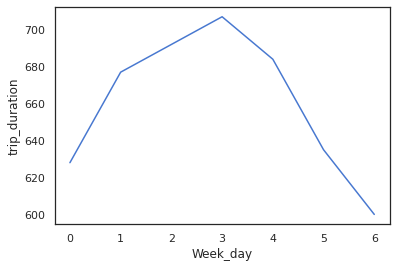

In [148]:
summary_wdays_avg_duration = pd.DataFrame(nycc.groupby(['day_of_week'])['trip_duration'].median())
X=[0,1,2,3,4,5,6]
Y=summary_wdays_avg_duration['trip_duration']
sns.lineplot(X,Y)
plt.xlabel("Week_day")


**vendor_id vs Trip Duration**

Let's check how the trip duration varies for different vendors.

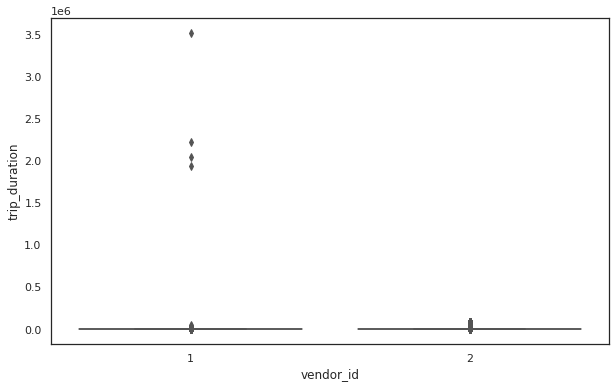

In [149]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=nycc)
plt.show()

Woah! This did not came out as expected. The only thing I can see from this boxplot is that for vendor 2, there are a number of outliers exceeding 24 hours while vendor 1 does not have such long trips.

There could be 2 solutions to this:

1. Remove the huge outliers and plot again
2. Look at median trip duration for both vendors on hourly basis
Let's try the first technique now and check trips below 50000 seconds only

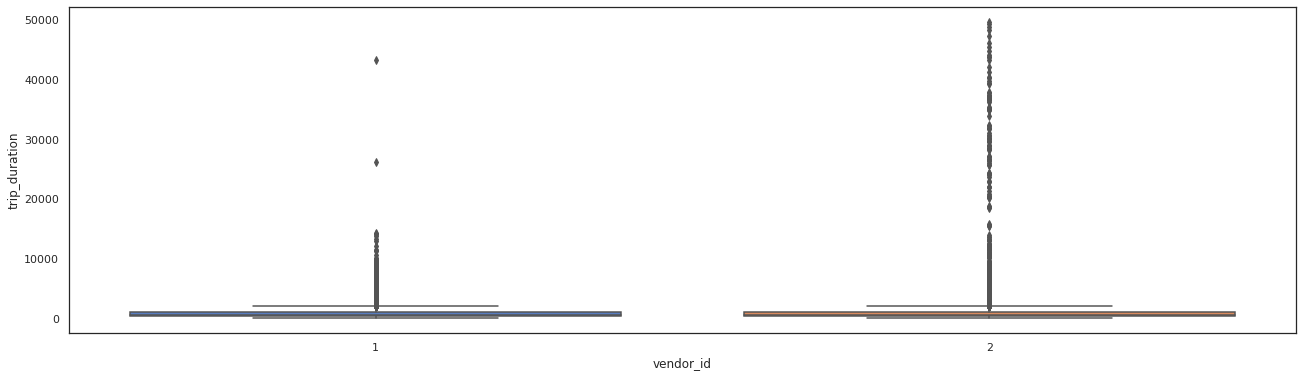

In [150]:
plt.figure(figsize=(22, 6))
df_sub = nycc[nycc['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=df_sub)
plt.show()


As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

**Trip Duration vs Passenger Count**

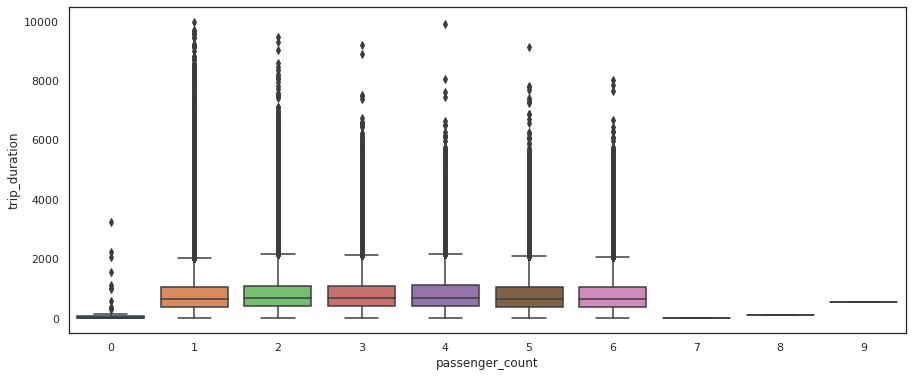

In [151]:
nycc.passenger_count.value_counts()
plt.figure(figsize=(15, 6))
df_sub = nycc[nycc['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()



* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

**Correlation Heatmap**

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

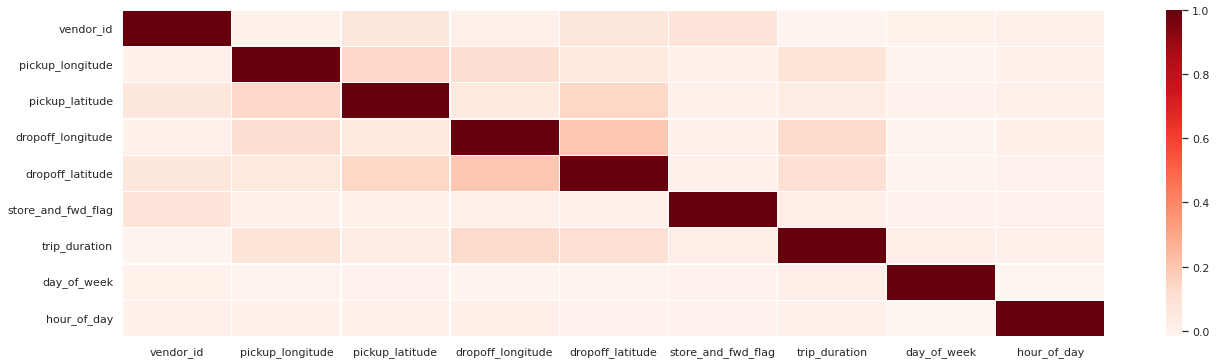

In [152]:
plt.figure(figsize=(22, 6))
df = nycc.drop(['id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count','check_trip_duration','log_trip_duration'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="Reds")

# **Preprocessing & Feature Extraction**
As is clear from the previous modules, we can only feed numeric features as input to our models. So our next task is to convert the features in numeric form. It is time to jump into getting our data ready for feeding into the model but before that it is important to use the variables to do some feature engineering as t.

Some of my ideas to create new variables and the reasons are as follows

* Difference between pickup and dropoff latitude - will give an idea about the distance covered which could be predictive
* Difference between pickup and dropoff longitude - same reason as above
* Haversine distance between pickup and dropoff co-ordinates - to capture the actual distance travelled
* Pickup minute - since pickup hour is an important variable, the minute of pickup might well have been predictive
* Pickup day of year - same reason as above

**DateTime Conversion**

The datetime features from csv files are read as strings and in order to easily extract features like day of week, month, year etc. we need to convert it into datetime format of python.

In [153]:
# converting strings to datetime features
nycc['pickup_datetime'] = pd.to_datetime(nycc.pickup_datetime)
nycc['dropoff_datetime'] = pd.to_datetime(nycc.dropoff_datetime)

In [154]:
# Log transform the Y values
df_y = np.log1p(nycc['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = nycc['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = nycc['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = nycc['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = nycc['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (nycc['pickup_datetime'] - nycc['pickup_datetime'].min()).dt.total_seconds()
#df.loc[:, 'pickup_week_hour'] = nycc['pickup_weekday'] * 24 + nycc['pickup_hour']

**Distance Features**

As discussed earlier, distance features must be important and must be included here

**Eucledian Distance** 

Let's Calculate the Eucledian distance between pickup and drop off location to get some idea on how far the pickup and dropoff points are since this would definitely impact the trip duration even though we know that cars can't fly

In [155]:

#displacement
y_dist= nycc['pickup_longitude'] - nycc['dropoff_longitude']
x_dist = nycc['pickup_latitude'] - nycc['dropoff_latitude']

#square distance
nycc['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
nycc['dist_sqrt'] = nycc['dist_sq'] ** 0.5

**Haversine Distance**

Let's calculate the distance (km) between pickup and dropoff points. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. We will also calculate the approximate angle at which the dropoff location lies wrt the pickup location. pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.

Haversine direction represents the information of angle of the line connecting the dropoff and pickup point over the surface of earth wrt equator.

In [156]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


nycc['haversine_distance'] = haversine_array(nycc['pickup_latitude'].values, 
                                                     nycc['pickup_longitude'].values, 
                                                     nycc['dropoff_latitude'].values, 
                                                     nycc['dropoff_longitude'].values)


df['direction'] = direction_array(nycc['pickup_latitude'].values, 
                                          nycc['pickup_longitude'].values, 
                                          nycc['dropoff_latitude'].values, 
                                          nycc['dropoff_longitude'].values)

**Binning**

The lattitude and longitude could be a bit noisy and it might be a good idea to bin them and create new features after rounding their values.

In [157]:
### Binned Coordinates ###
nycc['pickup_latitude_round3'] = np.round(nycc['pickup_latitude'],3)
nycc['pickup_longitude_round3'] = np.round(nycc['pickup_longitude'],3)

nycc['dropoff_latitude_round3'] = np.round(nycc['dropoff_latitude'],3)
nycc['dropoff_longitude_round3'] = np.round(nycc['dropoff_longitude'],3)

**One Hot Encoding**

Here, Vendor ID can be converted to one hot encoding or frequency encoding since in the raw data it has values 1 and 2 without any inherent order.

In [158]:
nycc.vendor_id.value_counts()

2    776965
1    675420
Name: vendor_id, dtype: int64

Now, there is not much difference in the frequencies of both and that might not make for an important feature. so we will just convert it to 0 and 1 by subtracting 1 from it

In [159]:
nycc['vendor_id'] = nycc['vendor_id'] - 1

In [160]:
np.sum(pd.isnull(nycc))

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
check_trip_duration         0
log_trip_duration           0
day_of_week                 0
hour_of_day                 0
dist_sq                     0
dist_sqrt                   0
haversine_distance          0
pickup_latitude_round3      0
pickup_longitude_round3     0
dropoff_latitude_round3     0
dropoff_longitude_round3    0
dtype: int64


Before we go on to build a model, we must drop the variables that should not be fed as features to the algorithms. We will drop

* id - Uniquely represents a sample in the train set
* pickup_datetime - Since we have extracted the datetime features, there is no need to keep the datetime column
* dropoff_datetime - If this is used to create features, it would be a leakage and we will get perfect model performance. Why? The time gap between dropoff_datetime and pickup_datetime is essentially what we are trying to predict
* trip_duration - This is the target variable so needs to be dropped
* store_and_fwd_flag - This variable is not available before the start of the trip and should not be used for modelling.

In [161]:
nycc = nycc.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag'], axis=1)

# **Model Building**
Now, before we go on to build the model, let us look at the dataset.

In [162]:
nycc.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,check_trip_duration,log_trip_duration,day_of_week,hour_of_day,dist_sq,dist_sqrt,haversine_distance,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.982155,40.767937,-73.964630,40.765602,455.0,6.122493,0,17,0.000313,0.017680,1.498521,40.768,-73.982,40.766,-73.965
1,0,1,-73.980415,40.738564,-73.999481,40.731152,663.0,6.498282,6,0,0.000418,0.020456,1.805507,40.739,-73.980,40.731,-73.999
2,1,1,-73.979027,40.763939,-74.005333,40.710087,2124.0,7.661527,1,11,0.003592,0.059934,6.385098,40.764,-73.979,40.710,-74.005
3,1,1,-74.010040,40.719971,-74.012268,40.706718,429.0,6.063785,2,19,0.000181,0.013438,1.485498,40.720,-74.010,40.707,-74.012
4,1,1,-73.973053,40.793209,-73.972923,40.782520,435.0,6.077642,5,13,0.000114,0.010690,1.188588,40.793,-73.973,40.783,-73.973


We have all numerical data types in our dataset now. Time to delve into model building. A very simple baseline could just be the mean of the values in the train set. Let's check the performance on that.

**Test Train Split**

We have all numbers in our dataset now. Time to delve into model building. But before that, we need to finalise a validation strategy to create the train and test sets. Here, we will do a random split and keep one third of the data in test set and remaining two third of data in the train set

In [163]:
#Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(nycc,df_y,test_size=1/3, random_state=0)

**Mean Prediction**

Before we go on to try any machine learning model, let us look at the performance of a basic model that just says the mean of trip duration in the train set is the prediction for all the trips in the test set.

In [164]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))

sqrt(mean_squared_error(ytest, mean_pred))

0.7903213744093935


**Cross validation**

Cross Validation is one of the most important concepts in any type of data modelling. It simply says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

we divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation.

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.


In [165]:
def cv_score(ml_model, rstate = 11,cols = nycc.columns):
    i = 1
    cv_scores = []
    df1 = nycc.copy()
    df1 = nycc[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

**Linear Regression**

Lets begin by using the simplest regression algorithm Linear regression to check the performance.